In [65]:
import os, sys
import numpy as np
import scipy.io as sio
from skimage import io
import skimage.transform
import matplotlib.pyplot as plt

sys.path.append('..')
import open3d as o3d
import trimesh

import face3d.face3d as face3d

from face3d.face3d import mesh
from face3d.face3d.morphable_model import MorphabelModel

import ipywidgets as widgets

In [159]:
mat_path = 'face3d/examples/Data/300W_LP/AFW/AFW_134212_1_0.mat'
bfm = MorphabelModel('face3d/examples/Data/BFM/Out/BFM.mat')

In [160]:
info = sio.loadmat(mat_path)
pose_para = info['Pose_Para'].T.astype(np.float32)
shape_para = info['Shape_Para'].astype(np.float32)
exp_para = info['Exp_Para'].astype(np.float32)
vertices = bfm.generate_vertices(shape_para, exp_para)
faces = bfm.full_triangles
face_center = np.mean(vertices, axis=0)
center_x, center_y, center_z = face_center[0], face_center[1], face_center[2]

y_min_index = np.argmin(vertices[:, 1])
vertex_at_y_min = vertices[y_min_index]

# Extract the z-value of this vertex
z_offset = vertex_at_y_min[2] - center_z

center_z += z_offset

In [182]:
def crop_and_shift_mesh(vertices, faces, z_offset):
    """
    Efficiently crop a mesh at a specified Z offset and shift it to z=0.

    :param vertices: Nx3 numpy array of vertices.
    :param faces: Mx3 numpy array of faces (indices into vertices).
    :param z_offset: Z value at which to crop the mesh.
    :return: Cropped and shifted vertices and faces.
    """
    # Filter vertices below the z_offset
    valid_vertices_mask = vertices[:, 2] >= z_offset
    cropped_vertices = vertices[valid_vertices_mask]

    # Shift the mesh so the base lies at z=0
    min_z = np.min(cropped_vertices[:, 2])
    cropped_vertices[:, 2] -= min_z

    # Normalize along the y-axis
    # y_max = np.max(cropped_vertices[:, 1])
    # y_min = np.min(cropped_vertices[:, 1])
    # y_range = y_max - y_min
    # cropped_vertices[:, 1] = (cropped_vertices[:, 1] - y_min) / y_range

    # # # Apply the same scale factor to x and z coordinates
    # scale_factor = 1 / y_range
    # cropped_vertices[:, 0] *= scale_factor
    # cropped_vertices[:, 2] *= scale_factor

    # Create a mapping from old vertex indices to new indices
    index_mapping = np.full(vertices.shape[0], -1, dtype=int)
    index_mapping[valid_vertices_mask] = np.arange(cropped_vertices.shape[0])

    # Update faces
    mapped_faces = index_mapping[faces]
    valid_faces_mask = np.all(mapped_faces >= 0, axis=1)
    cropped_faces = mapped_faces[valid_faces_mask]

    return cropped_vertices, cropped_faces

cropped_vertices, cropped_faces = crop_and_shift_mesh(vertices, faces, center_z)

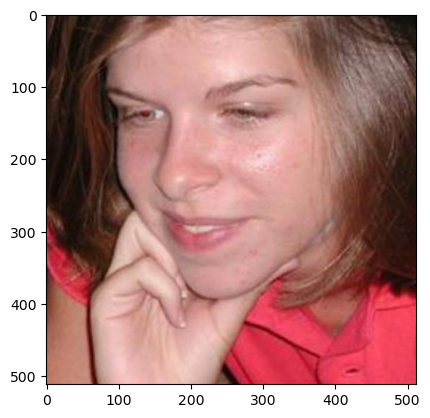

In [165]:
%matplotlib inline
image_path = 'predictions/test/AFW_134212_1_0.jpg'
image = io.imread(image_path)/255.
plt.imshow(image)
plt.show()

In [166]:
prediction_file = 'predictions/test/AFW_134212_1_0_prediction.npy'
predicted_posmap = np.load(prediction_file)
predicted_posmap = predicted_posmap.squeeze()
predicted_posmap.shape
predicted_posmap = (predicted_posmap - predicted_posmap.min()) / (predicted_posmap.max() - predicted_posmap.min())  # Normalize to [0, 1]
predicted_posmap = (predicted_posmap * 255).astype(np.uint8)

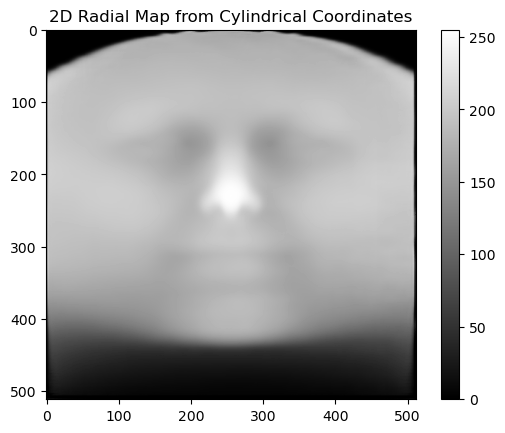

In [167]:
plt.imshow(predicted_posmap, cmap='gray')
plt.colorbar()
plt.title("2D Radial Map from Cylindrical Coordinates")
plt.show()

In [168]:
true_posmap_file = 'predictions/test/AFW_134212_1_0.npz'
true_posmap = np.load(true_posmap_file)[list(np.load(true_posmap_file).keys())[0]]
true_posmap = true_posmap.squeeze()
scale_factor = true_posmap.max() - true_posmap.min()
# true_posmap = (true_posmap - true_posmap.min()) / scale_factor  # Normalize to [0, 1]
# true_posmap = (true_posmap * 255).astype(np.uint8)

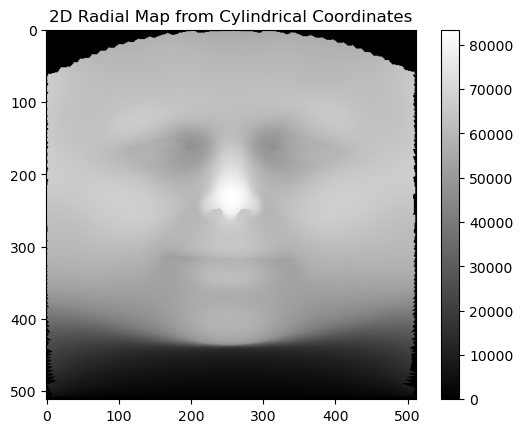

In [169]:
plt.imshow(true_posmap, cmap='gray')
plt.colorbar()
plt.title("2D Radial Map from Cylindrical Coordinates")
plt.show()

In [170]:
predicted_posmap_norm = predicted_posmap / 255.
# Pre-calculate constants
phi_values = (np.arange(512) / (512 - 1)) * np.pi - np.pi / 2
y_max = np.max(vertices[:, 1])
y_min = np.min(vertices[:, 1])
y_values = y_max - (np.arange(512) / (512 - 1)) * (y_max - y_min)

# Create mesh grids for phi and y
phi_grid, y_grid = np.meshgrid(phi_values, y_values)

# Flatten and filter out zero-radius points
valid_indices = predicted_posmap_norm != 0
r_flat = (predicted_posmap_norm[valid_indices] * scale_factor) + true_posmap.min()
phi_flat = phi_grid[valid_indices]
y_flat = y_grid[valid_indices]

# Convert back to Cartesian coordinates
x = r_flat * np.sin(phi_flat)
z = r_flat * np.cos(phi_flat)

# Combine the coordinates
reconstructed_prediction = np.vstack((x, y_flat, z)).T

In [171]:
filtered_vertices = reconstructed_prediction[reconstructed_prediction[:,2] >= 20000]
filtered_vertices = filtered_vertices[filtered_vertices[:,1] <= 55000]

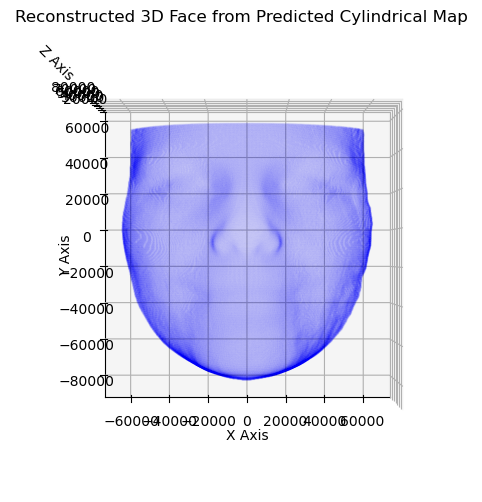

In [177]:
# Plotting the reconstructed vertices
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')

# Assuming reconstructed_vertices contains [x, y, z] coordinates
ax.scatter(filtered_vertices[:,0], filtered_vertices[:,1], filtered_vertices[:,2], color='blue', s=0.5, alpha=0.03)

ax.set_xlabel('X Axis')
ax.set_ylabel('Y Axis')
ax.set_zlabel('Z Axis')
ax.set_title('Reconstructed 3D Face from Predicted Cylindrical Map')
ax.view_init(elev=90, azim=270)
# ax.view_init(elev=90, azim=270)
plt.show()

In [178]:
# Pre-calculate constants
phi_values = (np.arange(512) / (512 - 1)) * np.pi - np.pi / 2
y_max = np.max(vertices[:, 1])
y_min = np.min(vertices[:, 1])
y_values = y_max - (np.arange(512) / (512 - 1)) * (y_max - y_min)

# Create mesh grids for phi and y
phi_grid, y_grid = np.meshgrid(phi_values, y_values)

# Flatten and filter out zero-radius points
valid_indices = true_posmap != 0
r_flat = true_posmap[valid_indices]
phi_flat = phi_grid[valid_indices]
y_flat = y_grid[valid_indices]

# Convert back to Cartesian coordinates
x = r_flat * np.sin(phi_flat)
z = r_flat * np.cos(phi_flat)

# Combine the coordinates
reconstructed_gt = np.vstack((x, y_flat, z)).T

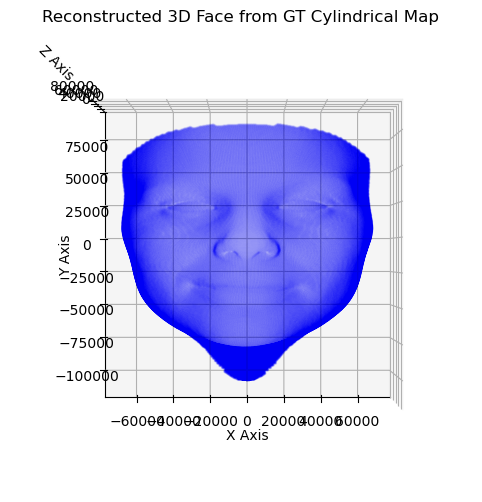

In [179]:
# Plotting the reconstructed vertices
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')

# Assuming reconstructed_vertices contains [x, y, z] coordinates
ax.scatter(reconstructed_gt[:,0], reconstructed_gt[:,1], reconstructed_gt[:,2], color='blue', s=1, alpha=0.03)

ax.set_xlabel('X Axis')
ax.set_ylabel('Y Axis')
ax.set_zlabel('Z Axis')
ax.set_title('Reconstructed 3D Face from GT Cylindrical Map')
ax.view_init(elev=90, azim=270)
# ax.view_init(elev=90, azim=270)
plt.show()

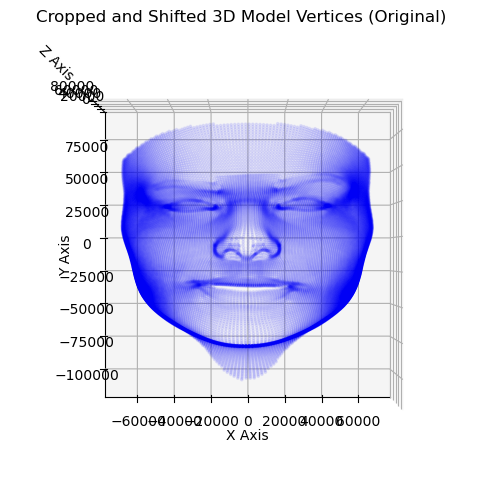

In [183]:
# Plotting the cropped vertices
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')

# Assuming reconstructed_vertices contains [x, y, z] coordinates
ax.scatter(cropped_vertices[:,0], cropped_vertices[:,1], cropped_vertices[:,2], color='blue', s=3, alpha=0.08)

ax.set_xlabel('X Axis')
ax.set_ylabel('Y Axis')
ax.set_zlabel('Z Axis')
ax.set_title('Cropped and Shifted 3D Model Vertices (Original)')
ax.view_init(elev=90, azim=270)
plt.show()

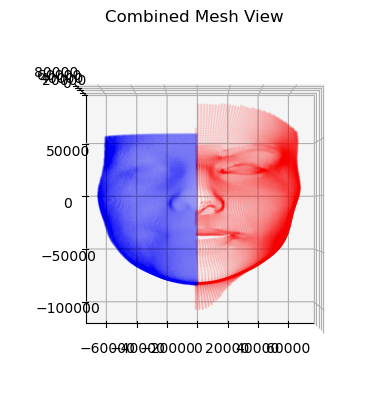

In [184]:
# Assuming scaled_reconstructed and scaled_shifted are already defined
# Split the models in half (modify the condition as per your model's orientation)
half_index_reconstructed = np.median(filtered_vertices[:, 0])
half_index_shifted = np.median(cropped_vertices[:, 0])

# Use only half of each model
half_reconstructed = filtered_vertices[filtered_vertices[:, 0] <= half_index_reconstructed]
half_shifted = cropped_vertices[cropped_vertices[:, 0] > half_index_shifted]

# Combine the halves
combined_vertices = np.vstack((half_reconstructed, half_shifted))

# Create the plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Plot the combined mesh
ax.scatter(half_reconstructed[:, 0], half_reconstructed[:, 1], half_reconstructed[:, 2], s=1, alpha=0.02, color='blue')
ax.scatter(half_shifted[:, 0], half_shifted[:, 1], half_shifted[:, 2], s=1, alpha=0.1, color='red')

# Set the view angle
ax.view_init(elev=90, azim=270)

ax.set_title("Combined Mesh View")

plt.show()

In [185]:
def calculate_point_to_surface_distances(mesh_vertices, mesh_faces, point_cloud):
    # Create a trimesh object from the mesh
    mesh = trimesh.Trimesh(vertices=mesh_vertices, faces=mesh_faces, process=False)

    # Use trimesh's nearest.on_surface to find the closest point on the mesh for each point in the point cloud
    closest_points, distances, _ = trimesh.proximity.closest_point(mesh, point_cloud)

    return distances

In [186]:
distances = calculate_point_to_surface_distances(cropped_vertices, cropped_faces, filtered_vertices)

In [155]:
# Calculate statistics
mean_distance = np.mean(distances)
median_distance = np.median(distances)
std_distance = np.std(distances)
hausdorff_distance = distances.max()

print(f"Mean Distance: {mean_distance}")
print(f"Median Distance: {median_distance}")
print(f"Standard Deviation: {std_distance}")
print(f"Hausdorff Distance: {hausdorff_distance}")

Mean Distance: 708.1508706760044
Median Distance: 565.1282939896605
Standard Deviation: 635.5254383139185
Hausdorff Distance: 4980.641398869256


In [136]:
gt_distances = calculate_point_to_surface_distances(cropped_vertices, cropped_faces, reconstructed_gt)

In [137]:
# Calculate statistics
mean_distance = np.mean(gt_distances)
median_distance = np.median(gt_distances)
std_distance = np.std(gt_distances)
hausdorff_distance = gt_distances.max()

print(f"Mean Distance: {mean_distance}")
print(f"Median Distance: {median_distance}")
print(f"Standard Deviation: {std_distance}")
print(f"Hausdorff Distance: {hausdorff_distance}")

Mean Distance: 270.03489961046694
Median Distance: 267.3540996777605
Standard Deviation: 144.43520839271392
Hausdorff Distance: 742.9113047144245


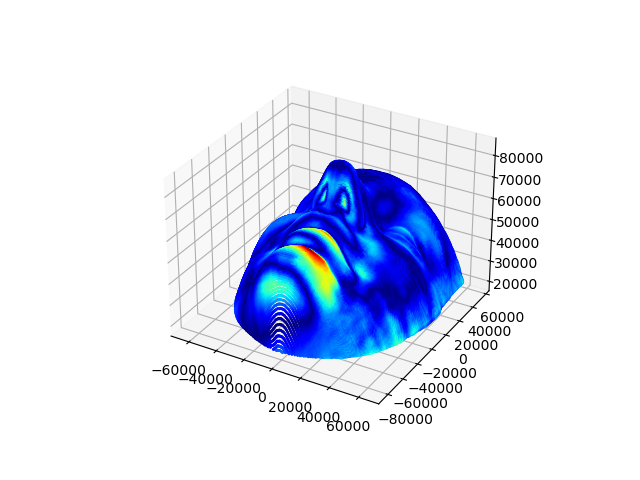

In [156]:
%matplotlib widget

normalized_distances = (distances - np.min(distances)) / (np.max(distances) - np.min(distances))

# Create a scatter plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(filtered_vertices[:, 0], filtered_vertices[:, 1], filtered_vertices[:, 2], c=normalized_distances, cmap='jet', s=0.5)

plt.show()